Two high-level analyses:
- Predict performance (accuracy) using a regression
- Classify users into 'bad' vs 'good'--still need to define this but perhaps the threshold is any user < 70% and any user >= 70%

For github issues and brainstorming features and analyses, use github:
- https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

In [55]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from dateutil.parser import parse
users = pd.read_csv('ml-users.csv') 
%matplotlib notebook

In [2]:
# the interactions table should really have the following header (but doesn't currently)
# audit_task_interaction_id, audit_task_id, action, gsv_panorama_id, lat, lng, heading, pitch, zoom, note, 
# timestamp, temporary_label_id, mission_id 

# I had to turn off exceptions because of parsing problems, including:
# https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues/3
# col_names = ['audit_task_interaction_id', 'audit_task_id', 'action', 'gsv_panorama_id', 'lat', 'lng', 
#            'heading', 'pitch', 'zoom', 'note', 'timestamp', 'temporary_label_id', 'mission_id']
# interactions = pd.read_csv('ml-interactions5000.csv', error_bad_lines=False,
#                           header=None, names = col_names, index_col=False) 
#interactions = pd.read_csv('ml-interactions5000.csv')

In [3]:
df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip') # load the full gzip tarball
#interactions = pd.read_csv('ml-interactions15000.csv')
#display(df_interactions.head())

# Do a little cleanup...
# In my initial analysis, i found that at least one row has a NaN value for an 'action' field. This should
# not happen. So, let's find that row (and others) that have this problem and remove them

# pd.isna checks for missing values (NaN values). It returns a boolean array where the index corresponds to
# row and the value corresponds to True/False indicating whether there is a NaN value
isna_result = pd.isna(df_interactions['action'])

print("Printing all rows where 'action' == NaN...")
display(df_interactions[isna_result])
df_interactions= df_interactions[~isna_result] # we want all rows where isna is False (that is, all rows *without* a NaN for 'action')

# As a test, we can again look for NaN 'action' cells
isna_result = pd.isna(df_interactions['action'])
print("Printing all rows where 'action' == NaN... there should be no rows")
display(df_interactions[isna_result])


Printing all rows where 'action' == NaN...


,ml-interactions.csv,user_id,audit_task_interaction_id,audit_task_id,action,gsv_panorama_id,lat,lng,heading,pitch,zoom,note,temporary_label_id,mission_id
18502779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Printing all rows where 'action' == NaN... there should be no rows


,ml-interactions.csv,user_id,audit_task_interaction_id,audit_task_id,action,gsv_panorama_id,lat,lng,heading,pitch,zoom,note,temporary_label_id,mission_id


In [116]:
df_interactions.rename(columns = {'ml-interactions.csv':'timestamp'}, inplace = True)

In [4]:
assert sum(df_interactions['action'].isna()) == 0

In [27]:
def scatter(series, name, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xlabel(name)
    ax.set_ylabel('accuracy')
    slope, intercept, r_value, p_value, std_err = stats.linregress(series, users[' accuracy'])
    p = np.poly1d([slope, intercept])
    ax.plot(series, p(series), 'r--')
    ax.scatter(series, users[' accuracy'])

In [6]:
# analyze avg num of mouse moves per pano vs accuracy

In [67]:
user_id_group = df_interactions.groupby('user_id')

In [9]:
keyboard_counts = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'].isin(['LowLevelEvent_keydown', 'KeyboardShortcut_ModeSwitch_NoSidewalk'])))

In [10]:
users = users.set_index('user_id')

In [11]:
users.head()

,username,labels_validated,role,accuracy
user_id,,,,
0e1ae564-6d72-4670-98e4-71369cc5ab26,AHLS6AZ1VTNH7,472,Turker,74.955595
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,A1A73A5Z4SDW06,393,Turker,84.551148
49723673-044d-4b47-855b-3bdebfe37073,shaunkuo,518,Registered,82.817869
7b1596af-14d4-4f2b-9e4e-71b1884db836,A1EK8YNHZHTW1J,98,Turker,82.178218
86d26e9d-010f-4802-88ba-680ae0a8e20d,A2AHXGFXPG6ZSR,157,Turker,38.497653


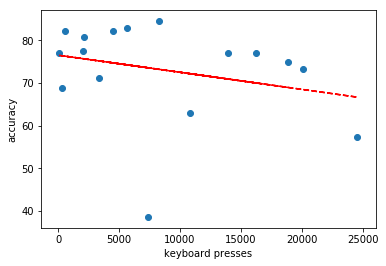

In [12]:
scatter(keyboard_counts, 'keyboard presses')

(array([1., 0., 0., 0., 1., 1., 1., 3., 4., 5.]),
 array([38.49765258, 43.10300215, 47.70835171, 52.31370128, 56.91905084,
        61.5244004 , 66.12974997, 70.73509953, 75.3404491 , 79.94579866,
        84.55114823]),
 <a list of 10 Patch objects>)

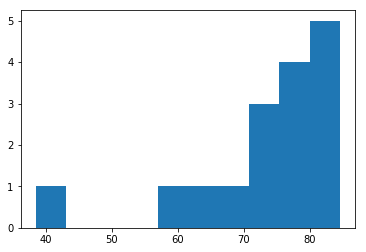

In [13]:
plt.figure()
plt.hist(users[' accuracy'])

In [15]:
num_missions = df_interactions.groupby('user_id').apply(lambda x: sum(x['action']=='MissionComplete'))

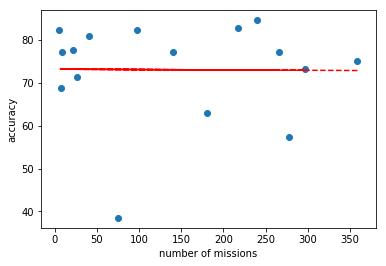

In [16]:
scatter(num_missions, 'number of missions')

Scatter matrix

In [18]:
keyboard_per_pano = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'].isin(['LowLevelEvent_keydown', 'KeyboardShortcut_ModeSwitch_NoSidewalk'])) / x['gsv_panorama_id'].unique().size)

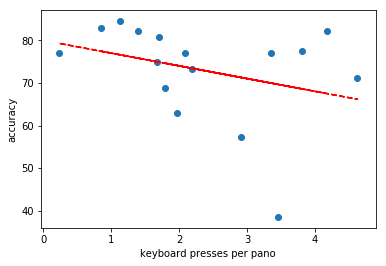

In [19]:
scatter(keyboard_per_pano, 'keyboard presses per pano')

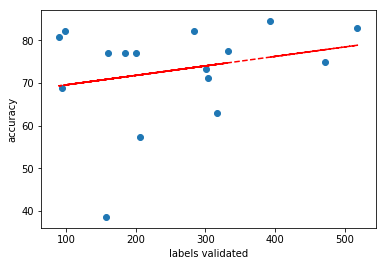

In [20]:
scatter(users[' labels_validated'], 'labels validated')

In [21]:
pov_per_panorama = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'] == 'POV_Changed') / x['gsv_panorama_id'].size)



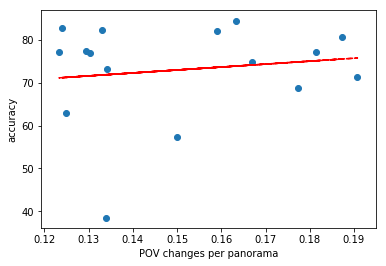

In [22]:
scatter(pov_per_panorama, 'POV changes per panorama')

In [23]:
avg_zoom = df_interactions.groupby('user_id').apply(lambda x: x['zoom'].mean())

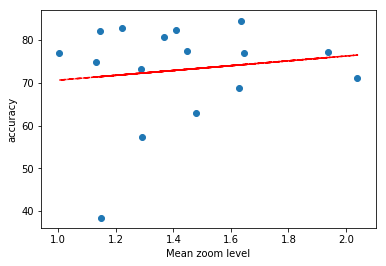

In [24]:
scatter(avg_zoom, 'Mean zoom level')

In [25]:
mouse_moves_per_pano = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'] == 'LowLevelEvent_mousemove') / x['gsv_panorama_id'].unique().size)

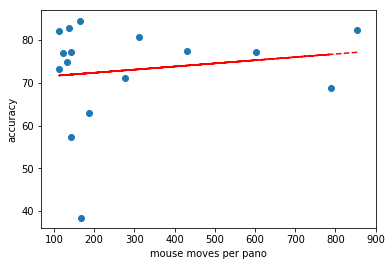

In [28]:
scatter(mouse_moves_per_pano, 'mouse moves per pano')

In [71]:
clicks_per_pano = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'] == 'LowLevelEvent_click') / x['gsv_panorama_id'].unique().size)
up_key_per_pano = df_interactions.groupby('user_id').apply(lambda x: sum(x['note'] == 'keyCode:38') / x['gsv_panorama_id'].unique().size)

<IPython.core.display.Javascript object>


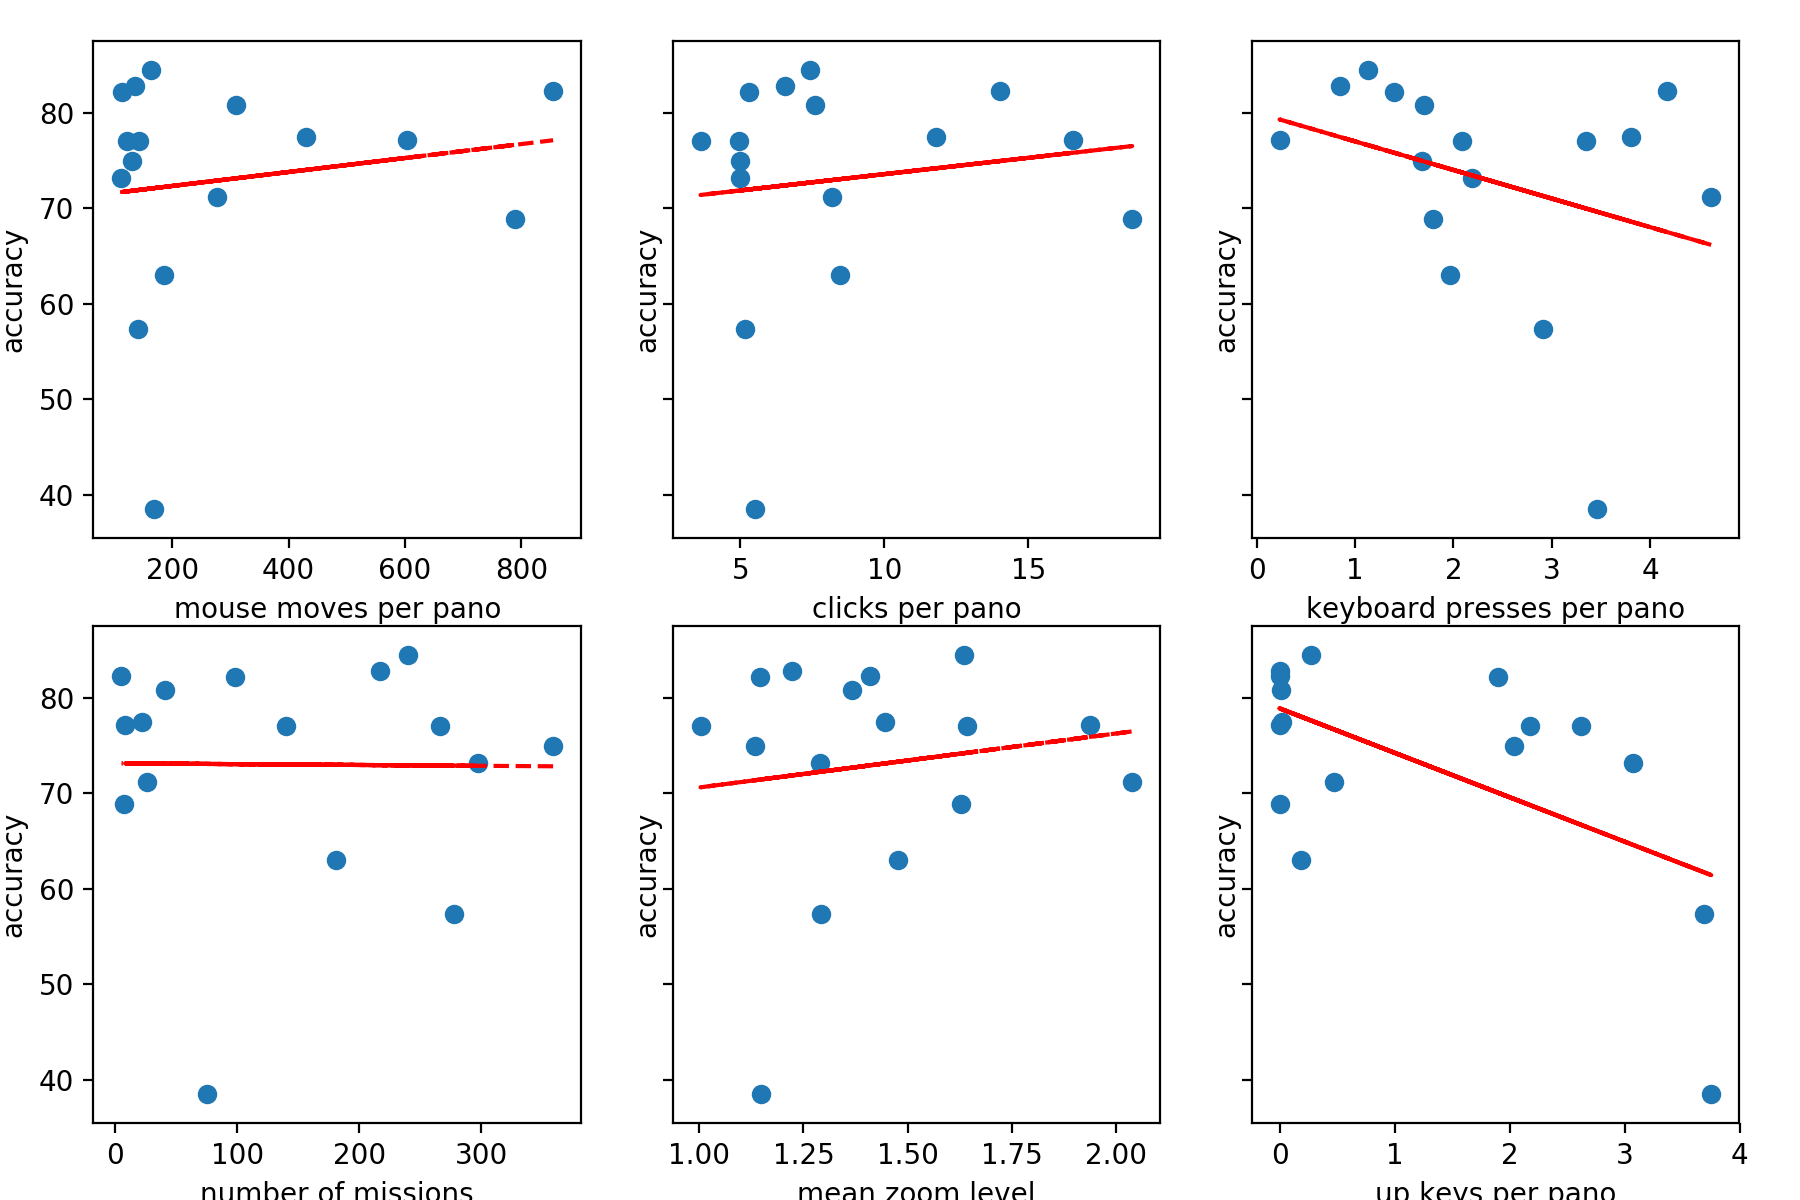

In [72]:
fig, ax = plt.subplots(ncols=3, nrows=2, sharey=True, figsize=(9, 6))
fig.tight_layout()
scatter(mouse_moves_per_pano, 'mouse moves per pano', ax=ax[0][0])
scatter(clicks_per_pano, 'clicks per pano', ax=ax[0][1])
scatter(keyboard_per_pano, 'keyboard presses per pano', ax=ax[0][2])
scatter(num_missions, 'number of missions', ax=ax[1][0])
scatter(avg_zoom, 'mean zoom level', ax=ax[1][1])
scatter(up_key_per_pano, 'up keys per pano', ax=ax[1][2])

<IPython.core.display.Javascript object>


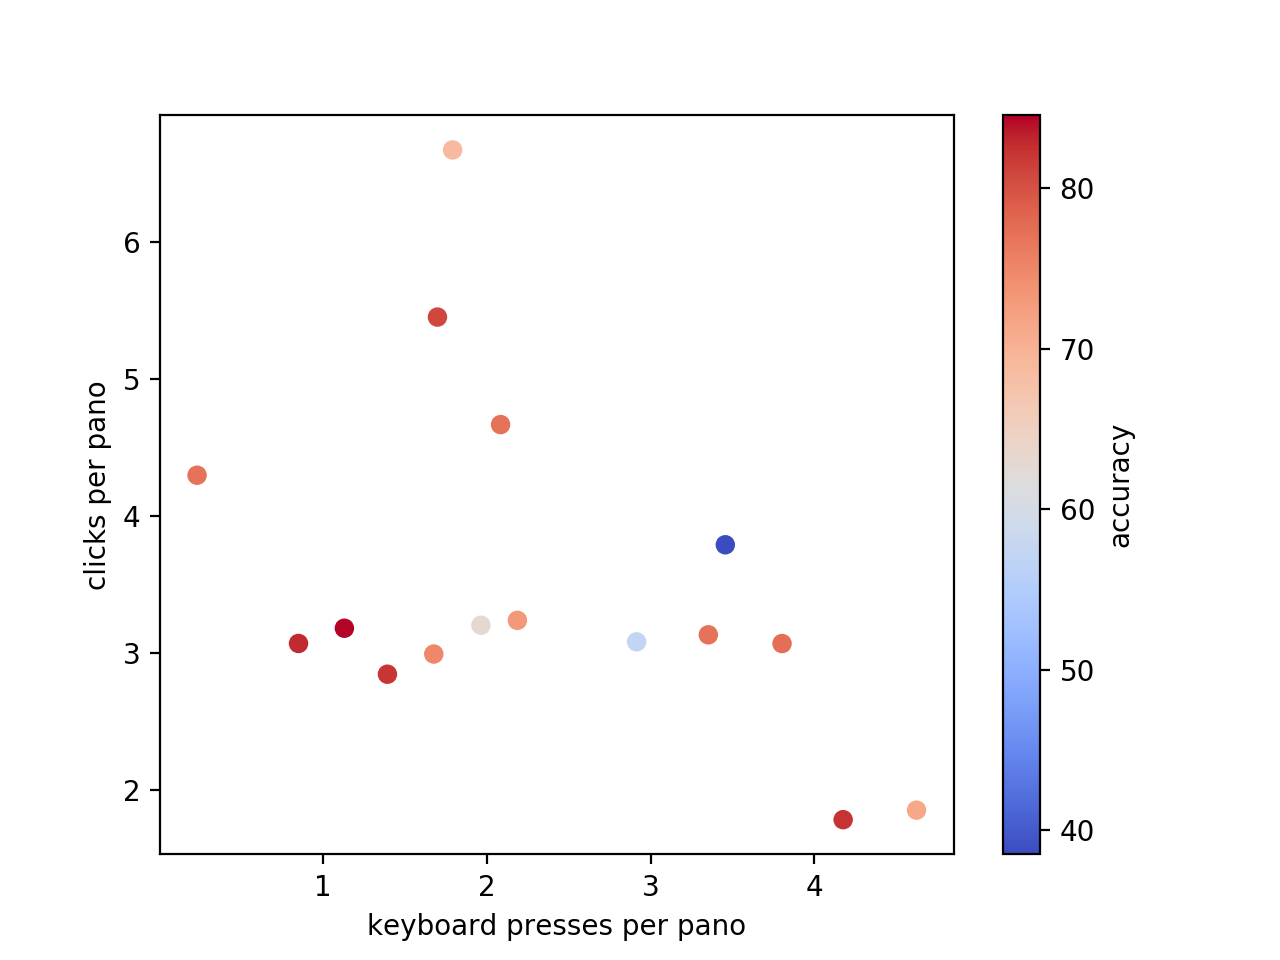

In [244]:
fig, ax = plt.subplots()
ax.set_xlabel('keyboard presses per pano')
ax.set_ylabel('clicks per pano')
sc = ax.scatter(keyboard_per_pano, med_time_pov_label, c=users[' accuracy'], cmap='coolwarm')
cbar = plt.colorbar(sc)
cbar.set_label('accuracy')

### Time between labeling and last POV_Changed 

In [235]:
def median_time_between_pov_change_and_label(u):
    pov_changed = u[u['action']=='POV_Changed']['timestamp'].apply(lambda x: parse(x)).sort_values()
    finish_labeling = u[u['action'] == 'LabelingCanvas_FinishLabeling']['timestamp'].apply(lambda x: parse(x))
    time_sec = np.array([(finish_labeling.iloc[index] - pov_changed.iloc[pov_changed.searchsorted(finish_labeling.iloc[index]) - 1]).total_seconds() for index in range(finish_labeling.size)])
    return np.mean(time_sec)

In [225]:
u = df_interactions[df_interactions['user_id'] == 'e4ff325c-309b-4ea6-8555-8f973e662362']
# u = df_interactions

In [226]:
pov_changed = u[u['action']=='POV_Changed']['timestamp'].apply(lambda x: parse(x))

In [227]:
finish_labeling = u[u['action'] == 'LabelingCanvas_FinishLabeling']['timestamp'].apply(lambda x: parse(x))

In [228]:
pov_changed = pov_changed.sort_values()

In [229]:
time_sec = np.array([(finish_labeling.iloc[index] - pov_changed.iloc[pov_changed.searchsorted(finish_labeling.iloc[index]) - 1]).total_seconds() for index in range(finish_labeling.size)])
    

In [230]:
# reject outliers
quartile_1, quartile_3 = np.percentile(time_sec, [25, 75])
iqr = quartile_3 - quartile_1
time_sec = time_sec[(time_sec < quartile_3 + (iqr * 1.5)) & (time_sec > quartile_1 - (iqr * 1.5))]

<IPython.core.display.Javascript object>


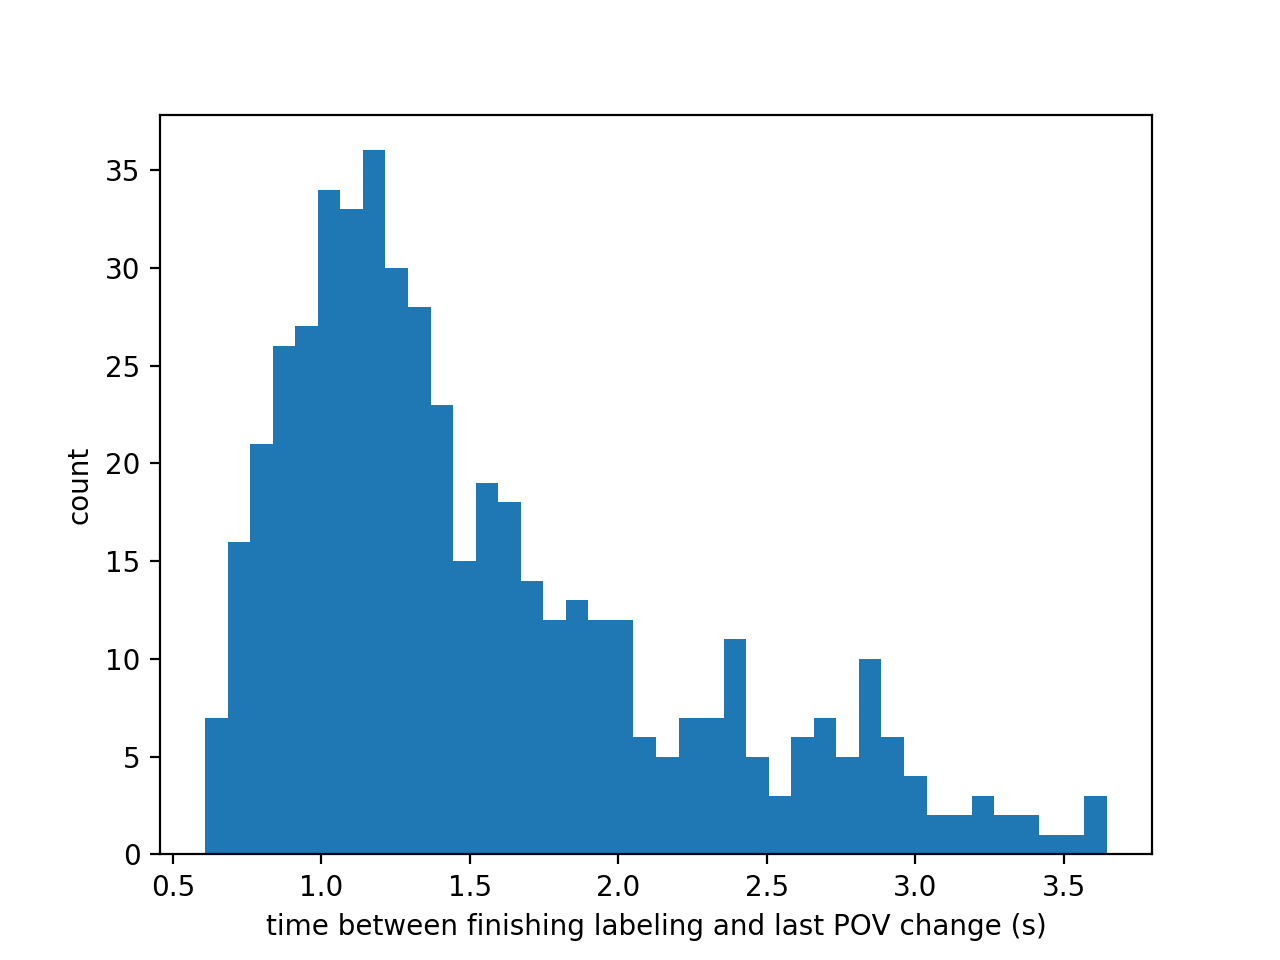

Text(0, 0.5, 'count')

In [231]:
plt.figure()
plt.hist(time_sec, bins=40)
plt.xlabel('time between finishing labeling and last POV change (s)')
plt.ylabel('count')

In [236]:
med_time_pov_label = df_interactions.groupby('user_id').apply(lambda x: median_time_between_pov_change_and_label(x))

<IPython.core.display.Javascript object>


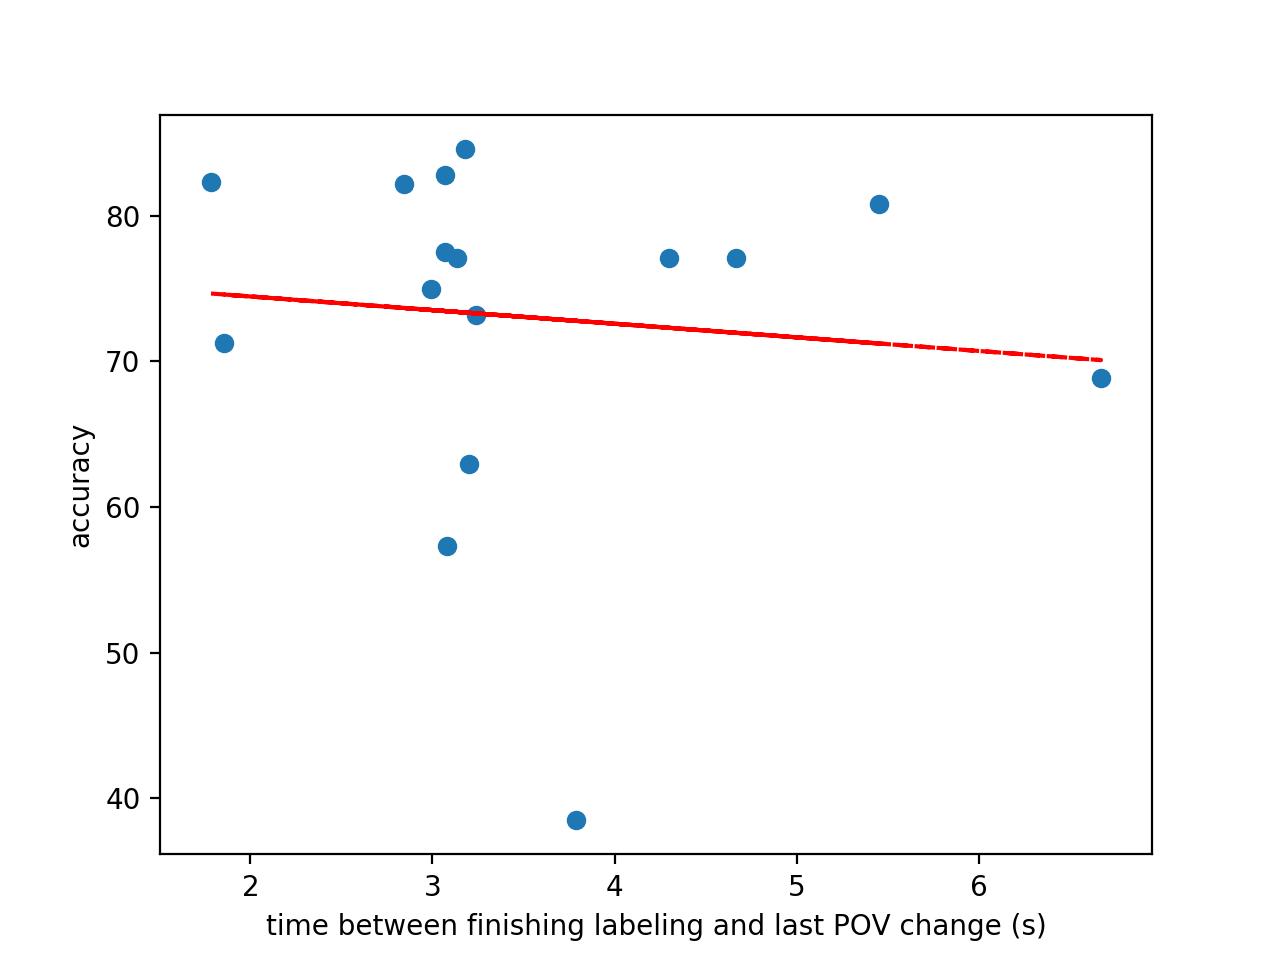

In [238]:
scatter(med_time_pov_label, 'time between finishing labeling and last POV change (s)')

### Amount of pano seen

In [ ]:
pov_size = 135 # size of view in degrees

In [261]:
u = df_interactions[df_interactions['user_id'] == 'bf16418a-4c99-4fd6-99c6-7e8b40fbe17b'].sort_values('timestamp')

In [262]:
u.groupby('gsv_panorama_id').apply(lambda x: print(x[x['action'] == 'POV_Changed']['heading'].unique().size))

19
19
1
37
48
20
65
13
17
10
66
46
34
1
7
62
1
1
6
1
28
6
1
1
1
1
67
8
29
1
1
1
120
1
21
58
1
1
7
1
36
1
22
1
5
20
7
46
50
32
1
47
1
32
56
15
10
7
1
15
1
18
101
73
30
1
2
1
1
1
37
17
13
22
2
1
19
17
13
1
9
19
1
41
7
143
38
127
13
24
15
63
1
58
1
20
19
1
14
9
1
29
59
6
55
1
18
1
16
30
21
1
37
19
12
67
7
6
1
1
88
25
1
1
64
6
1
65
4
13
1
1
1
1
1
16
17
1
1
196
26
21
1
1
35
0
54
1
1
1
1
1
5
19
17
41
52
1
27
30
18
12
39
107
1
1
66
1
1
38
5
21
34
1
1
1
61
1
1
34
1
1
25
15
9
34
1
58
16
6
29
26
1
205
1
1
64
15
15
1
7
20
28
1
2
12
13
1
43
1
8
107
1
4
18
6
8
1
16
1
13
12
9
6
26
1
5
72
30
1
1
79
16
1
26
72
1
1
5
84
27
1
41
36
11
1
27
19
33
137
1
1
30
78
2
36
41
15
1
1
73
60
1
1
37
4
15
28
17
5
5
16
1
109
40
1
5
19
1
1
1
26
76
1
4
36
1
16
11
26
9
16
104
1
52
20
1
15
1
13
16
4
1
1
13
5
219
1
5
1
1
7
9
1
1
1
1
1
1
53
2
81
34
82
1
4
11
1
31
1
7
39
29
25
1
36
13
22
1
1
5
14
12
1
17
13
105
73
10
8
16
20
1
28
130
3
1
1
20
1
136
13
14
22
1
66
22
22
11
6
12
1
170
9
1
23
7
1
10
1
1
1
1
30
45
2
1
8
13
1
128


65
77
40
1
47
13
1
5
46
4
35
11
59
1
1
4
1
10
51
8
43
1
21
1
46
1
1
13
1
1
112
11
42
4
42
1
43
1
1
5
24
34
1
198
23
1
18
60
44
38
30
1
6
13
1
56
180
8
1
22
95
63
124
56
16
7
13
28
18
15
1
46
1
1
1
19
7
12
16
18
4
34
1
14
8
26
1
5
44
36
1
1
79
1
91
29
20
46
29
22
1
158
21
54
14
1
1
1
41
1
39
32
6
72
10
1
1
23
47
3
4
1
17
1
4
5
26
14
107
1
15
5
16
2
12
1
1
1
7
15
9
1
10
35
12
6
36
1
12
1
1
1
2
1
39
1
14
16
1
23
5
39
1
4
8
8
13
6
13
1
18
178
1
7
34
1
16
19
10
1
30
1
23
14
5
16
1
1
89
23
1
1
1
62
3
39
92
1
8
2
61
1
36
1
28
1
1
1
11
1
15
83
1
1
5
80
111
1
1
3
1
14
16
22
37
28
10
1
30
21
23
7
1
14
1
22
1
4
19
1
23
1
1
26
1
26
38
18
51
13
1
12
57
5
9
66
39
1
20
25
13
12
1
1
1
1
1
59
7
1
19
24
1
59
1
4
25
21
6
1
1
1
4
12
1
36
22
10
1
3
32
18
16
1
25
8
42
1
1
1
1
14
25
9
1
29
35
18
26
16
42
16
1
1
1
57
15
65
41
20
74
4
8
49
22
16
2
10
89
8
18
1
1
13
5
1
1
6
20
1
1
1
33
118
5
19
34
1
9
36
61
3
23
14
6
19
15
110
16
1
25
120
1
22
1
13
1
38
5
1
47
1
1
204
1
10
2
1
1
1
1
146
21
20
6
67
1
16
67
108
4

""


In [288]:
k = u[(u['gsv_panorama_id'] == 'yswXpbti65Rk8pcuuB5IAQ') & (u['action'] == 'POV_Changed')]

In [303]:
timestamps = k['timestamp'].apply(lambda x: parse(x))
timedeltas = (timestamps - timestamps.iloc[0]).apply(lambda x: x.total_seconds())
headings = k['heading']

<IPython.core.display.Javascript object>


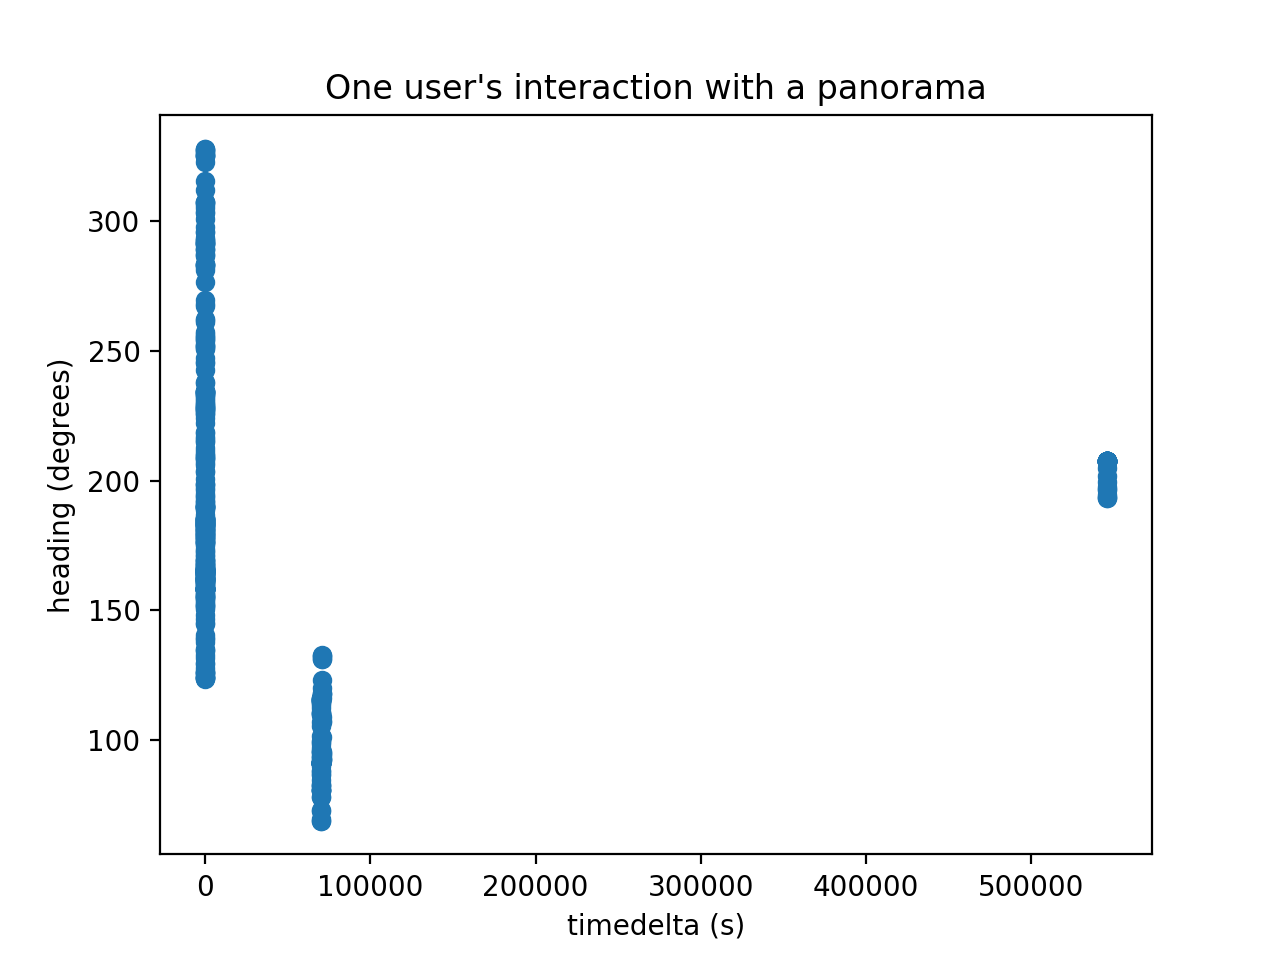

In [306]:
plt.figure()
plt.title('One user\'s interaction with a panorama')
plt.ylabel('heading (degrees)')
plt.xlabel('timedelta (s)')
plt.scatter(timedeltas, headings)

In [ ]:
mask = timedeltas < 100
timedeltas = timedeltas[mask]
headings = headings[mask]
